In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

In [3]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True
)
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
train_dataset = tf.data.Dataset.from_generator(lambda: train,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
train_dataset = train_dataset.repeat()


validation_dataset = tf.data.Dataset.from_generator(lambda: validation,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
validation_dataset = validation_dataset.repeat()


test_dataset = tf.data.Dataset.from_generator(lambda: test,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
test_dataset = test_dataset.repeat()

In [5]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [6]:
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout


vgg16_base_model = VGG16(input_shape=(180,180,3),include_top=False,weights='imagenet')
vgg16_base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [7]:
vgg16_model = Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])
    
model = Sequential()
model.add(vgg16_model.layers[0])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
vgg16_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)
    

In [8]:
r = vgg16_model.fit(train_dataset,
          epochs=30,
          validation_data=validation_dataset,
          class_weight=class_weight,
          steps_per_epoch=200,
          validation_steps=40)

Epoch 1/30
200/200 [==============================] - 1061s 5s/step - loss: 0.2697 - accuracy: 0.6475 - precision: 0.8735 - recall: 0.6151 - val_loss: 1.9816 - val_accuracy: 0.5500 - val_precision: 0.4706 - val_recall: 1.0000
Epoch 2/30
200/200 [==============================] - 1055s 5s/step - loss: 0.2238 - accuracy: 0.6869 - precision: 0.8966 - recall: 0.6488 - val_loss: 1.8765 - val_accuracy: 0.6250 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 3/30
200/200 [==============================] - 1053s 5s/step - loss: 0.2060 - accuracy: 0.7200 - precision: 0.9139 - recall: 0.6877 - val_loss: 0.9760 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.0625
Epoch 4/30
200/200 [==============================] - 1046s 5s/step - loss: 0.1978 - accuracy: 0.7556 - precision: 0.9193 - recall: 0.7486 - val_loss: 1.1208 - val_accuracy: 0.6750 - val_precision: 0.6486 - val_recall: 1.0000
Epoch 5/30
200/200 [==============================] - 1036s 5s/step - loss: 0.1783 - accuracy: 0

Text(0.5, 1.0, 'Accuracy Evolution')

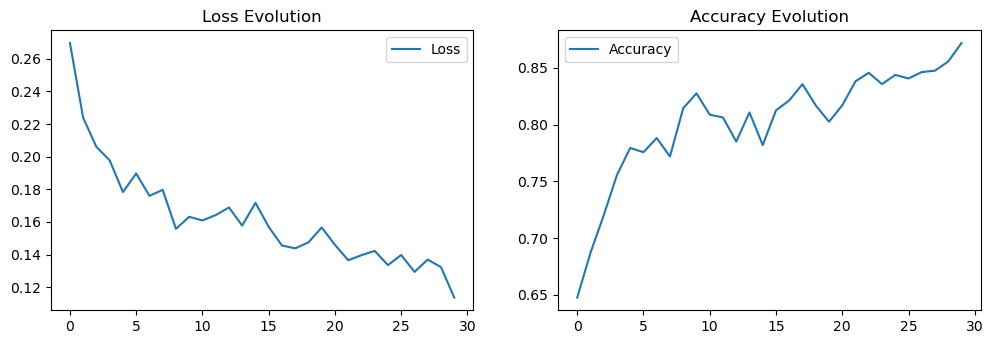

In [9]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [10]:
evaluation =vgg16_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 125s 198ms/step - loss: 1.5934 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Test Accuracy: 62.50%
652/652 [==============================] - 844s 1s/step - loss: 0.8318 - accuracy: 0.7437 - precision: 0.7435 - recall: 1.0000
Train Accuracy: 74.37%


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

pred = vgg16_model.predict(test)

conf_mat = confusion_matrix(test.classes, pred > 0.5)
print(conf_mat)

class_report = classification_report(test.classes, pred > 0.5, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print(class_report_df)


624/624 [==============================] - 124s 199ms/step
[[145  89]
 [173 217]]
              precision    recall  f1-score     support
0              0.455975  0.619658  0.525362  234.000000
1              0.709150  0.556410  0.623563  390.000000
accuracy       0.580128  0.580128  0.580128    0.580128
macro avg      0.582563  0.588034  0.574463  624.000000
weighted avg   0.614210  0.580128  0.586738  624.000000


In [14]:
model.save('my_model_vggv2.h5')
print("done")

done


In [ ]:
#59.46/50.79
#68.91/87.15